In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn keras tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_validate,StratifiedKFold
from keras.layers import Dense
from keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,roc_auc_score
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.utils import to_categorical

In [3]:
data = pd.read_csv('data.csv')
data_cleaned = data.drop(columns=['patient_id','er_status_measured_by_ihc'])
data_cleaned.head()

C:\Users\ryana\AppData\Local\Temp\ipykernel_1856\4014827458.py:1: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data.csv')


,cancer_type,age_at_diagnosis,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,Breast Invasive Ductal Carcinoma,54.29,High,1,LumB,1,Positive,3.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,0,0
1,Breast Invasive Ductal Carcinoma,43.45,Moderate,0,LumA,4,Positive,1.0,LOSS,Negative,...,0,0,0,0,0,0,0,0,0,0
2,Breast Invasive Ductal Carcinoma,74.11,High,0,LumB,3,Positive,3.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,0,0
3,Breast Invasive Ductal Carcinoma,51.87,High,0,LumA,3,Positive,2.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,0,0
4,Breast Invasive Ductal Carcinoma,87.18,Moderate,0,LumB,1,Positive,3.0,GAIN,Positive,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def fill_missing_with_mode(data):
    # Get a list of columns with missing values
    columns_with_missing_values = data.columns[data.isnull().any()].tolist()
    
    # Iterate over each column with missing values
    for column_name in columns_with_missing_values:
        # Loop until no more null values in the column
        while data[column_name].isnull().any():
            # Iterate over rows in the DataFrame
            for i, row in data[data[column_name].isnull()].iterrows():
                # Filter the data for the same cancer type
                same_type_data = data[data['cancer_type'] == row['cancer_type']]
                
                # Try to find 5 other entries; if fewer, take as many as available
                if len(same_type_data) > 5:
                    sample = same_type_data.sample(n=5)
                else:
                    sample = same_type_data
                
                # Calculate the mode of the selected sample
                mode_value = sample[column_name].mode()
                
                # If mode calculation is successful and not empty, use the mode to fill the missing value
                if not mode_value.empty:
                    data.at[i, column_name] = mode_value.iloc[0]
                else:
                    # If no mode available (all values are different or no other samples), we might choose to do nothing or use a global mode
                    # Here we're choosing to use the global mode as a fallback
                    global_mode = data[column_name].mode()[0]
                    data.at[i, column_name] = global_mode

    return data

# Example usage for the column 'cellularity'
updated_data = fill_missing_with_mode(data_cleaned)

missing_values = updated_data.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]

# Display columns with missing values and their counts
print(columns_with_missing_values)

Series([], dtype: int64)


In [5]:
X = data_cleaned.drop(columns=['cancer_type'])
y = data_cleaned['cancer_type']

cols_one_hot = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() <= 5]
cols_label = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() > 5]

# Initialize the transformers list for the ColumnTransformer
transformers = []

# Loop through each column in X to apply appropriate encoding
for column in X.columns:
    if X[column].dtype == 'object' or X[column].dtype == 'int':  # Adjusted to ensure we catch int types too
        X[column] = X[column].astype(str)  # Convert everything to string to avoid mixed type errors
        unique_values = X[column].nunique()
        if unique_values > 5:
            # Use LabelEncoder for columns with more than 5 unique values
            transformers.append((column, LabelEncoder(), [column]))  # LabelEncoder usage adjusted
        else:
            # Use OneHotEncoder for columns with 5 or fewer unique values
            transformers.append((column, OneHotEncoder(), [column]))

# Manually apply LabelEncoder to the relevant columns before ColumnTransformer
for name, encoder, columns in transformers:
    if isinstance(encoder, LabelEncoder):
        X[columns[0]] = encoder.fit_transform(X[columns[0]])  # Directly encode the column in the DataFrame
        # Remove label encoded columns from transformer list since they are already processed
        transformers = [(n, e, c) for n, e, c in transformers if e is not LabelEncoder]

# Setup remaining transformations with OneHotEncoder using ColumnTransformer
preprocessor_X = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), [name for name, encoder, _ in transformers if isinstance(encoder, OneHotEncoder)])
    ],
    remainder='passthrough'  # Keep all other columns that do not need encoding
)

# Fit and transform X with the defined ColumnTransformer for OneHotEncoder
X_transformed = preprocessor_X.fit_transform(X)

# Label encode y
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

# Print the final shape of X_transformed to verify feature count
print("Number of features in X after encoding:", X_transformed.shape[1])

Number of features in X after encoding: 734


In [6]:
from IPython.display import display
import pandas as pd

# Assume cols_label and cols_one_hot are defined and scoped correctly from a previous cell
onehot_features = preprocessor_X.named_transformers_['onehot'].get_feature_names_out()
label_features = cols_label  # Using the columns designated for label encoding
remainder_features = [col for col in X.columns if col not in cols_one_hot and col not in cols_label]

# Combining all feature names
all_features = list(onehot_features) + label_features + remainder_features

# Create the DataFrame from the transformed data
X_transformed_df = pd.DataFrame(X_transformed, columns=all_features[:X_transformed.shape[1]])

# Verify column counts and consistency
if len(all_features[:X_transformed.shape[1]]) != X_transformed_df.shape[1]:
    print(f"Warning: Column count mismatch. {len(all_features[:X_transformed.shape[1]])} names for {X_transformed_df.shape[1]} actual columns.")
else:
    print("Column names and counts are consistent.")

# Find the index of 'muc16_mut' column
muc16_mut_index = X_transformed_df.columns.get_loc("muc16_mut")

# Select columns after 'muc16_mut'
selected_columns = X_transformed_df.columns[muc16_mut_index + 1:]

# Display the selected columns for the first 30 rows of the DataFrame
display(X_transformed_df[selected_columns].head())


Column names and counts are consistent.


,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,cdh1_mut,dnah2_mut,kmt2d_mut,...,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17
0,3.0,1.0,3.0,2.0,5.160,111.100000,0.0,1.0,80.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,7.0,2.046,76.866667,1.0,1.0,23.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,6.0,3.0,6.056,118.700000,0.0,1.0,28.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,10.0,3.028,220.233333,1.0,1.0,14.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,1.0,2.0,1.0,5.052,28.600000,0.0,0.0,26.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assume X_transformed_df and y_encoded are your features and labels respectively

# Perform a stratified split for 80% training and 20% testing across all classes
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed_df, y_encoded, train_size=0.8, random_state=42, stratify=y_encoded
)

# Print the sizes of each dataset to confirm the splits
print("Training set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)


Training set size: (1196, 734) (1196,)
Test set size: (300, 734) (300,)


In [8]:
# Convert y_train to a pandas Series for easy counting
y_train_series = pd.Series(y_train)

# Get counts of each class
class_counts_train = y_train_series.value_counts()

# Print the counts with original class names using inverse transform of LabelEncoder
class_names_counts_train = pd.Series(class_counts_train.index).apply(
    lambda x: label_encoder_y.inverse_transform([x])[0])
class_counts_train.index = class_names_counts_train

# Display the class counts with names
print(class_counts_train)

# Class Number 0: Breast Invasive Ductal Carcinoma
# Class Number 1: Breast Invasive Lobular Carcinoma
# Class Number 2: Breast Invasive Mixed Mucinous Carcinoma
# Class Number 3: Breast Mixed Ductal and Lobular Carcinoma


Breast Invasive Ductal Carcinoma             959
Breast Mixed Ductal and Lobular Carcinoma    132
Breast Invasive Lobular Carcinoma             91
Breast Invasive Mixed Mucinous Carcinoma      14
Name: count, dtype: int64


In [9]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Assuming y_train contains the class labels, and X_train contains the features

# Setup the RandomUnderSampler to reduce class 0 to 500 instances
rus = RandomUnderSampler(sampling_strategy={0: 500})

# Apply the resampling to the training data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Check the new class distribution to ensure it is as expected
print("New class distribution:", np.bincount(y_resampled))

# Now X_resampled and y_resampled contain the undersampled data where class 0 has exactly 500 instances

New class distribution: [500  91  14 132]


In [10]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [11]:
# Check unique class labels in y_train to ensure they match the SMOTE configuration
print(np.unique(y_train))



[0 1 2 3]


In [12]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Custom SMOTE application
smote = SMOTE(sampling_strategy='auto', random_state=42)  # You can also use a dictionary to specify exact numbers
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

# Adjust the XGBoost model
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_balanced)),
    max_depth=8,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,  # Increased gamma
    min_child_weight=2,  # Increased min_child_weight
    random_state=42
)

# Train and predict
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_balanced), y=y_balanced)
weight_dict = {class_label: weight for class_label, weight in zip(np.unique(y_balanced), class_weights)}

# Apply these weights to create an array of sample weights for each instance in the dataset
sample_weights = np.array([weight_dict[y] for y in y_balanced])

# Train the XGBoost model using the sample weights
xgb_model.fit(X_balanced, y_balanced, sample_weight=sample_weights)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Generate the classification report and print it
target_names = label_encoder_y.classes_  # This ensures all classes are included
report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:")
print(report)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Classification Report:
                                           precision    recall  f1-score   support

         Breast Invasive Ductal Carcinoma       0.82      0.98      0.89       240
        Breast Invasive Lobular Carcinoma       0.25      0.09      0.13        23
 Breast Invasive Mixed Mucinous Carcinoma       1.00      0.50      0.67         4
Breast Mixed Ductal and Lobular Carcinoma       0.50      0.03      0.06        33

                                 accuracy                           0.80       300
                                macro avg       0.64      0.40      0.44       300
                             weighted avg       0.74      0.80      0.74       300

Overall Accuracy: 0.80
Confusion Matrix:
[[235   4   0   1]
 [ 21   2   0   0]
 [  2   0   2   0]
 [ 30   2   0   1]]


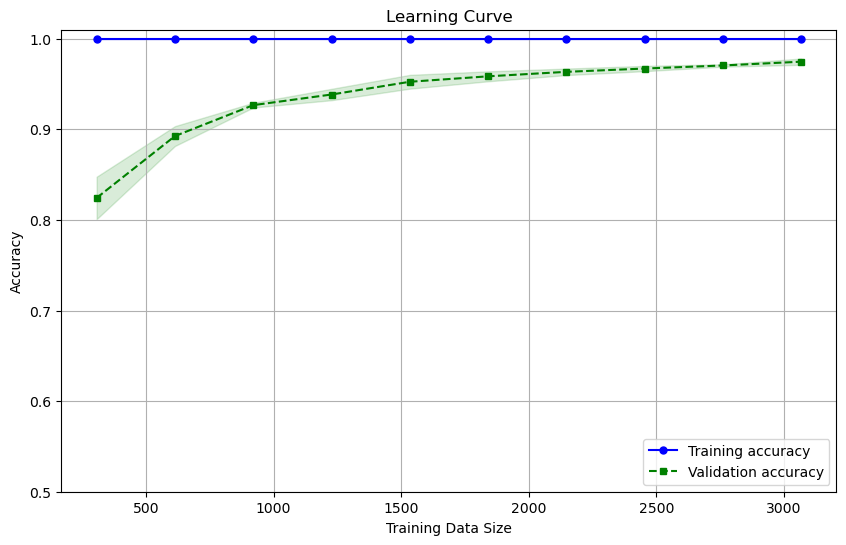

Classification Report:
                                           precision    recall  f1-score   support

         Breast Invasive Ductal Carcinoma       0.82      0.98      0.89       240
        Breast Invasive Lobular Carcinoma       0.25      0.09      0.13        23
 Breast Invasive Mixed Mucinous Carcinoma       1.00      0.50      0.67         4
Breast Mixed Ductal and Lobular Carcinoma       0.50      0.03      0.06        33

                                 accuracy                           0.80       300
                                macro avg       0.64      0.40      0.44       300
                             weighted avg       0.74      0.80      0.74       300



In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import classification_report

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup the learning curve parameters
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb_model, X=X_balanced, y=y_balanced, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cv, scoring='accuracy', n_jobs=-1, shuffle=True, random_state=42,
    fit_params={'sample_weight': sample_weights}
)

# Calculate the average and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.ylim([0.5, 1.01])  # Adjust based on your accuracy range
plt.show()

# Generate and print the classification report
y_pred = xgb_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:")
print(report)


In [14]:
import pickle

with open('model_pickle','wb') as f:
    pickle.dump(xgb_model,f)

In [15]:
import pickle

with open('model_pickle','rb') as f:
    model = pickle.load(f)